# Predicting Used Car Prices

We will build a supervised machine learning model based on multivariate linear regression to predict the price of used cars. Our dataset Car-Sales-Data (source unknown) contains the following information:

- Brand - the vehicle's manufacturer
- Price - the selling price in USD
- Body - the body style of the vehicle
- Mileage - odometer reading in 1000's of kilometers
- EngineV - the volume of the car's engine in liters
- Engine Type - gas/diesel/petrol/other
- Registration - boolean, whether the car is registered
- Year - when the vehicle was manufactured
- Model - the vehicle's model name


# Outline
1. Prepare the data
    - Remove missing values, duplicates, extraneous variables
    - Remove outliers - get boxplots to visualize
    - Transform Price variable for normality - show distribution
    - Dummy Coding - convert categorical variables into numeric format
2. Exploratory Analysis
    - correlation heatmap
    - scatterplots and histograms for continuous data
    - interactive Tableau dasboards (links provided)
3. Stepwise Regression via Backwards Elimination 
    - Determine which variables to keep and which to discard from the model ( performed in R. See r_notebook.ipynb file )
4. Check Linearity and Assumptions for Linear Modelling ( performed in R. See r_notebook.ipynb file )
    - plot Mileage, EngineV, and Year against Price
5.  Building the Model
    - Scale the Variables - ensure all the variables are fitted to the same scale ( use StandardScaler in Scikit-Learn Library )
    - Train/Test split the Data - 80% for training, 20% for testing
    - get accuracy score
    - get error score using Root Mean Square Error
6. Model Validation
    - Use K folds cross validation
7. Conclusion
    - plot a visual representation of the model's accuracy
    
###


> ### Import necessary libraries

In [1]:
import jupytab
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

from IPython import display
import scipy as scp
import statsmodels.api as sm
import plotly
import plotly.express as px
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



### Import the dataset

In [2]:
carSales = pd.read_csv("Car-Sales-Data.csv")
data = carSales.copy()

### Snapshot of the dataset

In [3]:
# Get a small subset of the data for viewing purposes
data10 = pd.DataFrame(data.iloc[0:10,])

In [4]:
# Style the pandas dataframe

# caption
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "200%"),
                   ("color", 'darkgrey')])]
# Change size of table and of font
data10.style.set_caption('Used Cars').set_table_styles(styles).set_table_attributes('style="font-size: 17px"').hide(axis = 'index')


Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
BMW,4200.000000,sedan,277,2.000000,Petrol,yes,1991,320
Mercedes-Benz,7900.000000,van,427,2.900000,Diesel,yes,1999,Sprinter 212
Mercedes-Benz,13300.000000,sedan,358,5.000000,Gas,yes,2003,S 500
Audi,23000.000000,crossover,240,4.200000,Petrol,yes,2007,Q7
Toyota,18300.000000,crossover,120,2.000000,Petrol,yes,2011,Rav 4
Mercedes-Benz,199999.000000,crossover,0,5.500000,Petrol,yes,2016,GLS 63
BMW,6100.000000,sedan,438,2.000000,Gas,yes,1997,320
Audi,14200.000000,vagon,200,2.700000,Diesel,yes,2006,A6
Renault,10799.000000,vagon,193,1.500000,Diesel,yes,2012,Megane
Volkswagen,1400.000000,other,212,1.800000,Gas,no,1999,Golf IV


# 1. Data Preprocessing

 ### Find and Remove Missing values

In [5]:
# Subset a snapshot of the data for viewing purposes
data20 = pd.DataFrame(data.iloc[24:45,])
# Display nan's
data20.style.set_caption('nan\'s in Used Cars').set_table_styles(styles).set_table_attributes('style="font-size: 17px"').hide(axis = 'index').highlight_null(null_color="salmon")


Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
Audi,24900.000000,sedan,163,4.200000,Diesel,yes,2008,A8
Volkswagen,20800.000000,crossover,151,3.000000,Diesel,yes,2008,Touareg
Audi,6500.000000,sedan,330,2.400000,Petrol,yes,1999,A6
Mercedes-Benz,13566.000000,other,171,2.200000,Other,no,2011,Vito
Mitsubishi,8500.000000,hatch,65,1.300000,Petrol,yes,2010,Colt
Mercedes-Benz,nan,crossover,0,4.600000,Petrol,yes,2016,GLS 500
Audi,2900.000000,sedan,1,2.300000,Gas,yes,1989,100
BMW,21500.000000,other,72,3.000000,Petrol,yes,2007,Z4
Mitsubishi,17900.000000,crossover,87,3.800000,Gas,yes,2008,Pajero Wagon
BMW,28500.000000,crossover,160,4.800000,Gas,yes,2008,X5


In [6]:
print("Original Shape:",data.shape)
# Remove missing values        
data = data.dropna()
print("     New Shape:",data.shape)

Original Shape: (4345, 9)
     New Shape: (4025, 9)


#
 ### Find and Remove Duplicates
 #### Check for presence of duplicates:

In [7]:
# Method 1

# check for duplicate values with a statement
for value in data.duplicated():
    if value == True:
        print('Yes')
# show    
data.duplicated()

Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes


0       False
1       False
2       False
3       False
4       False
        ...  
4339    False
4340    False
4341    False
4342    False
4344    False
Length: 4025, dtype: bool

#### Display a subset of all duplicate rows:

In [8]:
# Method 2
# subset the data to the duplicates 
duplicateRows = data[data.duplicated()]

#view duplicate rows
duplicateRows

styles1 = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "200%"),
                    ("color", 'black' )])]
# Change size of table and of font
duplicateRows.style.set_caption('Duplicate Rows').set_table_styles(styles1).set_table_attributes('style="font-size: 17px"').hide(axis = 'index')

Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
Mercedes-Benz,199999.000000,crossover,0,5.500000,Petrol,yes,2016,GLS 63
Mercedes-Benz,199999.000000,crossover,0,5.500000,Petrol,yes,2016,GLS 63
BMW,47000.000000,other,5,2.000000,Petrol,yes,2014,Z4
Volkswagen,24900.000000,sedan,1,1.600000,Diesel,yes,2016,Jetta
BMW,75555.000000,sedan,30,4.400000,Petrol,yes,2014,550
Mercedes-Benz,20400.000000,sedan,190,1.800000,Gas,yes,2011,E-Class
Mercedes-Benz,47600.000000,van,0,2.200000,Diesel,yes,2016,Vito
Mitsubishi,15900.000000,crossover,180,3.000000,Gas,yes,2008,Pajero Wagon
Mercedes-Benz,47600.000000,van,0,2.200000,Diesel,yes,2016,Vito
Audi,39999.000000,crossover,45,2.000000,Diesel,yes,2014,Q5


#### Compare the dataset's size before and after removing duplicates:

In [9]:
print('Old shape:',data.shape)
# drop rows with duplicate values
data = data.drop_duplicates()
print('New shape:',data.shape)

Old shape: (4025, 9)
New shape: (3975, 9)


#


### Remove Extraneous information
##### 'Registration' variable
##### 'Model' variable
##### 'Petrol' rows

Since we're looking at used car pricing, we'll focus our attention to the cars that have registration. Once we filter out any unregistered vehicles, we can get rid of 'Registration'. We'll also drop the 'Model' variable, since most of a model's information is contained in the other columns; it doesn't serve our purpose besides giving a name to each car. Finally, we'll also get rid of the 'Petrol' engine types. 'Petrol' is another term for 'gasoline'; its use varies based on location. In fact, Europe tends to use the term 'petrol' and the United States 'gas'. Removing 'petrol' won't hinder the model's performance. Since we don't need it, we'll sweep it out with 'Registration' and 'Model'.

In [10]:
# Redefine dataframe
data10 = pd.DataFrame(data.iloc[0:10,])

# Show snapshot of the updated data
data10.style.set_caption("Used Cars").set_table_styles(styles).set_table_attributes('style="font-size: 17px"').hide(axis = 'index')


Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
BMW,4200.000000,sedan,277,2.000000,Petrol,yes,1991,320
Mercedes-Benz,7900.000000,van,427,2.900000,Diesel,yes,1999,Sprinter 212
Mercedes-Benz,13300.000000,sedan,358,5.000000,Gas,yes,2003,S 500
Audi,23000.000000,crossover,240,4.200000,Petrol,yes,2007,Q7
Toyota,18300.000000,crossover,120,2.000000,Petrol,yes,2011,Rav 4
Mercedes-Benz,199999.000000,crossover,0,5.500000,Petrol,yes,2016,GLS 63
BMW,6100.000000,sedan,438,2.000000,Gas,yes,1997,320
Audi,14200.000000,vagon,200,2.700000,Diesel,yes,2006,A6
Renault,10799.000000,vagon,193,1.500000,Diesel,yes,2012,Megane
Volkswagen,1400.000000,other,212,1.800000,Gas,no,1999,Golf IV


In [11]:
# Rename 'Engine Type' column so it's easier to work with
data.rename(columns = {'Engine Type':'EngineType'}, inplace = True)
data = data[data.Registration == 'yes']
data = data[data.EngineType != 'Petrol']

Now that the data has only registered vehicles, we can drop 'Registration'. We'll also drop the 'Model' column, since a car's model information is pretty much covered by its year, engine type, body, and manufacturer. 

In [12]:
# Remove 'Registration' and 'Model' variables
col = [6,8]
data.drop(data.columns[col], axis=1, inplace=True)

In [13]:
print("Original Shape:",carSales.shape)

Original Shape: (4345, 9)


In [14]:
# Redefine the data snapshot
data10 = pd.DataFrame(data.iloc[0:10,])

# Show snapshot of the updated data
data10.style.set_caption('Used Cars - more concise').set_table_styles(styles).set_table_attributes('style="font-size: 17px"').hide(axis = 'index')


Brand,Price,Body,Mileage,EngineV,EngineType,Year
Mercedes-Benz,7900.000000,van,427,2.900000,Diesel,1999
Mercedes-Benz,13300.000000,sedan,358,5.000000,Gas,2003
BMW,6100.000000,sedan,438,2.000000,Gas,1997
Audi,14200.000000,vagon,200,2.700000,Diesel,2006
Renault,10799.000000,vagon,193,1.500000,Diesel,2012
Renault,11950.000000,vagon,177,1.500000,Diesel,2011
Audi,9500.000000,vagon,165,2.700000,Gas,2003
Toyota,16000.000000,crossover,250,4.700000,Gas,2001
Renault,8600.000000,hatch,84,1.500000,Diesel,2012
Toyota,38233.000000,other,0,2.400000,Diesel,2016


#### Dataset's size after removing 'Registration', 'Model', and 'Petrol':

In [15]:
# get dataframe's dimensions
print("New Shape:",data.shape)

New Shape: (2224, 7)


#

 ### Check for Outliers
 ##### We'll need to remove outliers as well.

In [16]:
# Get a subset of the data housing only the numeric information
data1 = data[['Price','Mileage','EngineV','Year']]


>##### Get a visual...

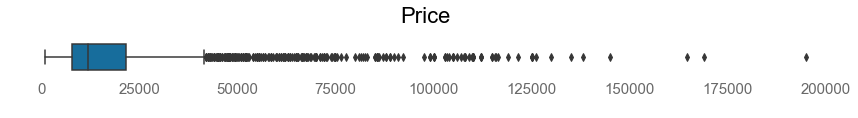

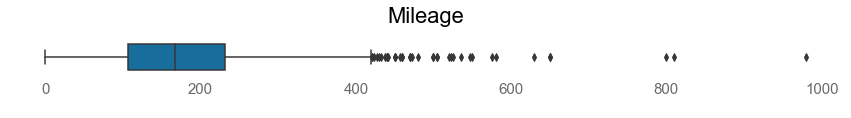

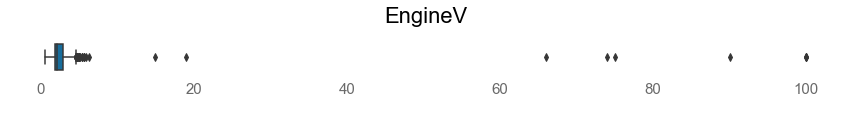

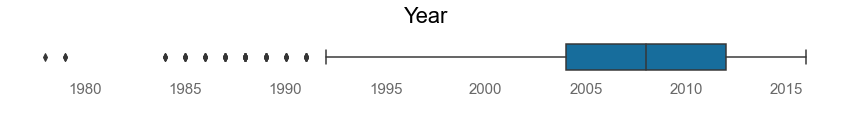

In [17]:
# Select the numeric variables
df1=data1.select_dtypes(exclude=['object'])

# Create a function to graph them on a boxplot. 
for column in df1:
        plt.figure(figsize=(15,.6))
        sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
        sns.set_palette("colorblind")
        sns.boxplot(data=df1, x=column)
        # format boxplots
        plt.title(column, pad = 18, color = 'black', size = 22)
        plt.xticks(color = 'dimgrey', size = 15)
        plt.xlabel(column, color = 'white')
    

##### From above, we see that we have quite a bit of outlier data in 'Price', 'Mileage', and 'EngineV'. 'Year' has some outliers, too but not as many. We'll therefore work on removing them with a function that will sweep through all the numeric information at once.


 ### Remove outliers

In [18]:
# Create a new copy of the data to work with
df1 = data1
# Create and define function to remove outliers. Method: Interquartile Range
def Remove_Outlier_Indices(df1):
    Q1 = df1.quantile(0.25)
    Q3 = df1.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR)))
    return trueList

In [19]:
# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(df1)

# Non-Outlier Subset of the Given Dataset
quant_data = pd.DataFrame(df1[nonOutlierList.all(1)])

 #### Compare the dataset's size before and after removing outliers:

In [20]:
print("Old shape:",df1.shape)
print("New shape:",quant_data.shape)

Old shape: (2224, 4)
New shape: (1841, 4)


#### We removed at least 600 outliers from the data! Let's check the distribution again:

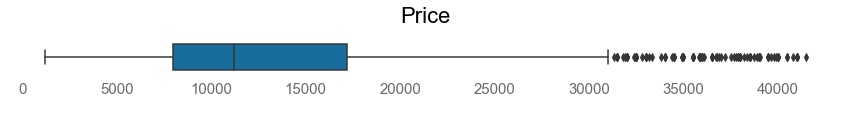

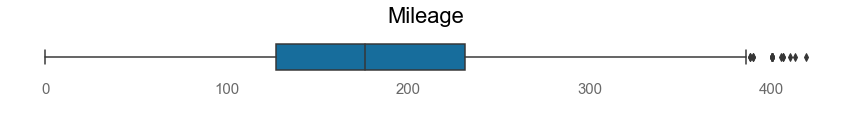

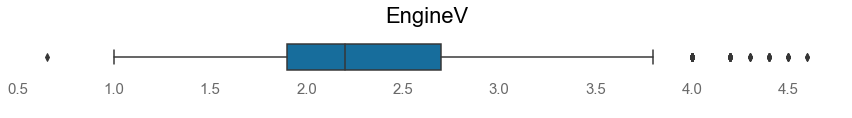

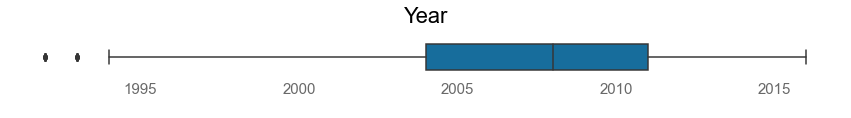

In [21]:
# Create a function to graph them on a boxplot. 
for column in quant_data:
        plt.figure(figsize=(15,.6))
        sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
        sns.set_palette("colorblind")
        sns.boxplot(data=quant_data, x=column)
        # format boxplots
        plt.title(column, pad = 18, color = 'black', size = 22)
        plt.xticks(color = 'dimgrey', size = 15)
        plt.xlabel(column, color = 'white')
    

Our variables are more centered now, with fewer outliers. However, we still seem to have outliers in the 'Price' column, which will pose a problem for the model. Take another look at its distribution:

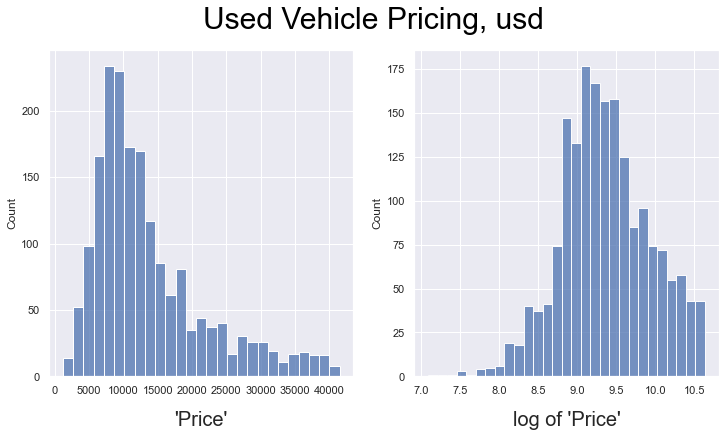

In [22]:
# Take the log of 'Price' 
quant_data['PriceLog'] = np.log(quant_data['Price'])
# Create an object with Seaborn library
sns.set()
# Get space for the plots. We want them next to each other for easy visual comparison
fig, ax = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('Used Vehicle Pricing, usd', color = 'black', size = 30)
# Get histograms of 'Price' and 'PriceLog' 
sns.histplot(data=quant_data, x="Price", ax=ax[0])
sns.histplot(data=quant_data, x = 'PriceLog', ax=ax[1])

# Format the axes
ax[0].set_xlabel("'Price'", size =20, labelpad = 15)
ax[1].set_xlabel("log of 'Price'", size = 20, labelpad = 15)

# Display
plt.show()

On the left plot, the curve of the 'Price' data is skewed to one side. Its lack of centeredness will bias our model, but we can correct for this if we transform it. For that we'll take the log of the 'Price' data, create another column housing the results of that operation, and then add it to our working dataframe. The plot on the right represents the new data. Notice that its curve is more centered. It's not perfectly symmetrical, but it's an improvement. We'll take it. 

# 
# 
#### One more look at the boxplots, and we'll see far fewer outliers:

Text(0.5, 0, '')

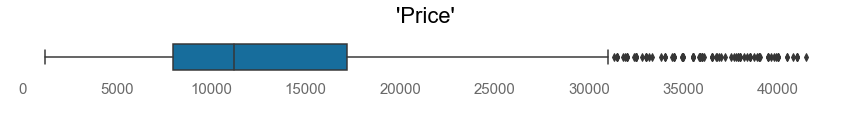

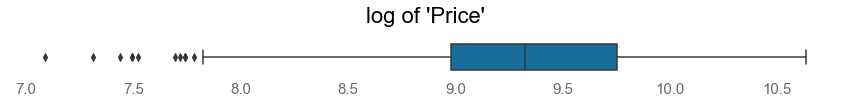

In [23]:
# Display 'Price' boxplot again

plt.figure(figsize = (15,.6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_palette("colorblind")
sns.boxplot(data=quant_data, x = 'Price')
# format boxplots
plt.title("'Price'", pad = 18, color = 'black', size = 22)
plt.xticks(color = 'dimgrey', size = 15)
plt.xlabel("j", color = 'white', size = 30)

# Graph the log of 'Price' on a boxplot for comparison

plt.figure(figsize = (15,.6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_palette("colorblind")
sns.boxplot(data=quant_data, x = 'PriceLog')
# format boxplots
plt.title("log of 'Price'", pad = 18, color = 'black', size = 22)
plt.xticks(color = 'dimgrey', size = 15)
plt.xlabel("", color = 'white')


In [24]:
col = 0
quant_data.drop(quant_data.columns[col], axis = 1, inplace = True)

 
### IMPORTANT! 
Because we transformed 'Price' with a log operation, from here on out our aim is to predict 'PriceLog' and not 'Price'


 ### Merge the Categorical Columns with the Cleaned Quantitative Columns
Now that we've taken care of our numeric data, we can combine it with our categorical data with a left join. 

In [25]:
# First, isolate the categorical columns in their own dataframe:
categ_data = data[['Brand','Body','EngineType']]

# Second, join the categorical and quantitative data:
cleaned_data = quant_data.join(categ_data)

 #### Compare the dataset's size before and after rejoining the data:

In [26]:
print("Old Shape:",quant_data.shape)
print("New Shape:",cleaned_data.shape)

Old Shape: (1841, 4)
New Shape: (1841, 7)


 We now have four numeric columns and three categorical columns in one dataframe.

## Dummy Coding



Since we are creating a machine learning model, we need to ensure all the data we use to train it is in numeric format. Since we have some categorical information, we'll need to convert it into numeric format, which we'll do via dummy coding.

In [27]:
# Create a fresh copy of the dataframe to work with
dummied_data = copy.deepcopy(cleaned_data)
dummied_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1841 entries, 7 to 4344
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mileage     1841 non-null   int64  
 1   EngineV     1841 non-null   float64
 2   Year        1841 non-null   int64  
 3   PriceLog    1841 non-null   float64
 4   Brand       1841 non-null   object 
 5   Body        1841 non-null   object 
 6   EngineType  1841 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 179.6+ KB


> - 'Brand'
> - 'Body'
> - 'Engine Type'

In [28]:
# Dummy code our first categorical variable: "Brand"
brand_dummy = pd.get_dummies(dummied_data['Brand'])
# Add the dummies to our dataframe as new variables
dummied_data = pd.concat([dummied_data,brand_dummy], axis = 1)

In [29]:
print("Old shape:",dummied_data.shape)
# Dummy code our second categorical variable: "Body"
Body_dummy = pd.get_dummies(dummied_data['Body'])
# Add the dummies to our dataframe as new variables
dummied_data = pd.concat([dummied_data,Body_dummy],axis=1)
# Check our work
print("New shape:",dummied_data.shape)

Old shape: (1841, 14)
New shape: (1841, 20)


In [30]:
print("Old shape:",dummied_data.shape)
# Dummy code our third categorical variable: "Engine Type"
Engine_type_dummy = pd.get_dummies(dummied_data['EngineType'])
# Add the dummies to our dataframe as new variables
dummied_data = pd.concat([dummied_data,Engine_type_dummy],axis=1)
# Check our work
print("New shape:",dummied_data.shape)

Old shape: (1841, 20)
New shape: (1841, 23)


 ### Get a visual for all the levels of our categories (Brand, Body, and Engine Type).

In [31]:
dummied_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1841 entries, 7 to 4344
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Mileage        1841 non-null   int64  
 1   EngineV        1841 non-null   float64
 2   Year           1841 non-null   int64  
 3   PriceLog       1841 non-null   float64
 4   Brand          1841 non-null   object 
 5   Body           1841 non-null   object 
 6   EngineType     1841 non-null   object 
 7   Audi           1841 non-null   uint8  
 8   BMW            1841 non-null   uint8  
 9   Mercedes-Benz  1841 non-null   uint8  
 10  Mitsubishi     1841 non-null   uint8  
 11  Renault        1841 non-null   uint8  
 12  Toyota         1841 non-null   uint8  
 13  Volkswagen     1841 non-null   uint8  
 14  crossover      1841 non-null   uint8  
 15  hatch          1841 non-null   uint8  
 16  other          1841 non-null   uint8  
 17  sedan          1841 non-null   uint8  
 18  vagon   

In [32]:
dummied_data.head()

,Mileage,EngineV,Year,PriceLog,Brand,Body,EngineType,Audi,BMW,Mercedes-Benz,...,Volkswagen,crossover,hatch,other,sedan,vagon,van,Diesel,Gas,Other
7,200,2.7,2006,9.560997,Audi,vagon,Diesel,1,0,0,...,0,0,0,0,0,1,0,1,0,0
8,193,1.5,2012,9.287209,Renault,vagon,Diesel,0,0,0,...,0,0,0,0,0,1,0,1,0,0
10,177,1.5,2011,9.388487,Renault,vagon,Diesel,0,0,0,...,0,0,0,0,0,1,0,1,0,0
12,165,2.7,2003,9.159047,Audi,vagon,Gas,1,0,0,...,0,0,0,0,0,1,0,0,1,0
15,84,1.5,2012,9.059517,Renault,hatch,Diesel,0,0,0,...,0,0,1,0,0,0,0,1,0,0


 ### Drop redundant dummies
#####
- 'Volkwagen' from 'Brand'
- 'Sedan' from 'Body'
- 'Diesel' from 'Engine Type'
#####
 Now that we have each level of our categorical variables properly represented, we can go ahead and remove 1 dummy from each, since that information can be obtained by referencing the other dummies. For each dummied variable, we will remove the category with the larger fraction of cases to serve as the reference category. Therefore, we'll remove 'Volkswagen' from 'Brand', 'sedan' from 'Body', and 'Diesel' from 'Engine Type'.
#####
#### Compare the dataset's size before and after dropping redundant dummies:

In [33]:
# Remove the dummies by column index number
print('Old Shape:', dummied_data.shape)
col = [13,17,20]
dummied_data.drop(dummied_data.columns[col], axis = 1, inplace = True)
print('New Shape:',dummied_data.shape)

Old Shape: (1841, 23)
New Shape: (1841, 20)


In [34]:
# Create a new dataframe with the updated discrete variables
quant_data1=dummied_data[['PriceLog','Mileage','EngineV','Year']]


# 2. Exploratory Analysis

In this section, we'll get to know our data a little better. With it cleaned and ready for analysis, we can explore the relationships among variables, their distributions, and a myriad of other information. 


### Correlations


Looking at relationships between the numeric variables with a correlation matrix: The darker the color (green or purple), the higher the relationship.
#

In [35]:
corr1 = quant_data1.corr().round(2)
corr1.style.background_gradient(cmap='PRGn')

,PriceLog,Mileage,EngineV,Year
PriceLog,1.000000,-0.440000,0.360000,0.600000
Mileage,-0.440000,1.000000,0.190000,-0.660000
EngineV,0.360000,0.190000,1.000000,-0.270000
Year,0.600000,-0.660000,-0.270000,1.000000


In [36]:
bmw = -0.67e-03
mercedes = -7.639e-02
mitsu = -4.199e-01
renault = -5.5e-1
toyota = -1.22e-1
volk = -2.127e-1
hatch = -3.139e-1
bodyother = -3.093e-1
sedan = -2.41e-1
vagon = -2.72e-1
van = -4.22e-1
gas = -1.37e-1
engineother = -7.424e-2

##### Noteable correlations (the closer to the absolute value of 1, the stronger the relationship):
- -0.48 between 'Mileage' and 'Price'                   
- 0.37 between 'EngineV' and 'Price'                      
- -0.57 between 'Year' and 'Price'

Looks like the strongest one lies between a car's price and its year, which makes sense--practically speaking, the older the car, generally the lower its price.

#
### All things being equal, how much do the variables affect Price (log)?

In [37]:
mileage = -4.504e-2
enginev = 2.64e-1
year = 8.008e-2
bmw = -0.67e-03
mercedes = -7.639e-02
mitsu = -4.199e-01
renault = -5.5e-1
toyota = -1.22e-1
volk = -2.127e-1
hatch = -3.139e-1
bodyother = -3.093e-1
sedan = -2.41e-1
vagon = -2.72e-1
van = -4.22e-1
gas = -1.37e-1
engineother = -7.424e-2

In [38]:
# Style data

(pd.DataFrame({'feature': ['MILEAGE','ENGINEV','YEAR', 'BMW','MERC-BENZ','MITSUBISHI','RENAULT','TOYOTA','VOLKWAGEN','HATCH','OTHERBODY','SEDAN','VAGON','VAN','GAS','OTHERENGINE'],  
               'coefficient': [mileage, enginev, year, bmw, mercedes, mitsu,renault,toyota,volk,hatch,bodyother,sedan,vagon,van,gas,engineother]}).style
   .bar(color=['salmon', 'lightgreen'], align='mid')
   .set_properties(**{'text-align': 'center'})
   .set_table_styles([{'selector': 'th.col_heading', 
                       'props': 'text-align: center'}]).hide(axis = 'index')
   .set_caption("Feature Impacts on log of 'PRICE'").set_table_styles(styles))

feature,coefficient
MILEAGE,-0.045040
ENGINEV,0.264000
YEAR,0.080080
BMW,-0.000670
MERC-BENZ,-0.076390
MITSUBISHI,-0.419900
RENAULT,-0.550000
TOYOTA,-0.122000
VOLKWAGEN,-0.212700
HATCH,-0.313900


# Overview of our Variables 
We'll step back and get a good look at all our discrete variables at once. 

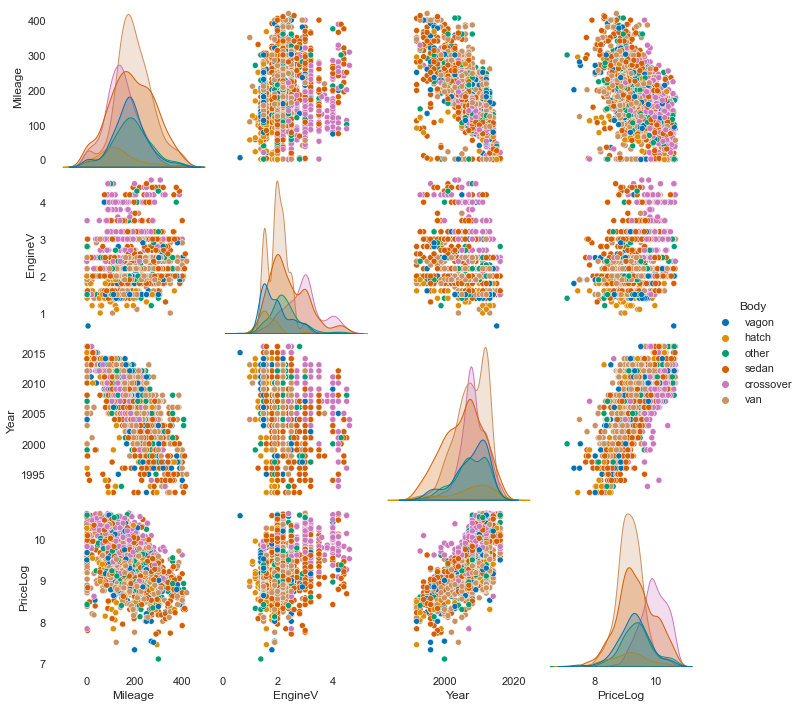

In [39]:
# Plot the bivariate and univariate distributions with pairplot() from the seaborn library
sns.pairplot(data=cleaned_data, hue = 'Body')


For each box sitting at the intersection of two variables, we have a scatterplot representing the relationship between the two. For example, the uppermost box farthest to the right displays the relationship between 'PriceLog' and 'Year'. Because each variable is represented on both the x- and y-axis of the grid, the bottom diagonal half of the grid mirrors the top diagonal half. The graphs stretching from top left to bottom right are the distribtion plots for all our variables, such as those we created above.

- Notes from the above grid:
    - More recent model years correlate with higher price values. So the newer the car, the more expensive it is.
    - The more recent the model year, generally the lower the mileage. So, older cars tend to have higher mileages.
    - As mileages increase, prices decrease. So, as a car's mileage racks up, its value goes down. 


### Take a closer look at the data with these interactive Tableau dashboards:
- Get to know the cars:

In [40]:
('https://public.tableau.com/app/profile/ariel6361/viz/UsedCars-BrandsBodiesEngines/BrandDashboard?publish=yes')

'https://public.tableau.com/app/profile/ariel6361/viz/UsedCars-BrandsBodiesEngines/BrandDashboard?publish=yes'

- How does a car's characteristics affect price?

In [41]:
('https://public.tableau.com/app/profile/ariel6361/viz/UsedVehicles-PriceVariation/PriceDashboard?publish=yes')

'https://public.tableau.com/app/profile/ariel6361/viz/UsedVehicles-PriceVariation/PriceDashboard?publish=yes'

- How does a car's metrics affect price?

In [42]:
('https://public.tableau.com/app/profile/ariel6361/viz/UsedVehicles-PriceVariation/TrendsDashboard?publish=yes')

'https://public.tableau.com/app/profile/ariel6361/viz/UsedVehicles-PriceVariation/TrendsDashboard?publish=yes'


# 3. Stepwise Regression via backward elimination
Now that we've gotten to know our data, it's time we begin constructing our model. We have TONS of information at our disposal. Let's see what we need and what we don't need to make this model successful. This will involve performing a hard check on everything in the data.

We will switch over to R to perform this and other tests. 

Please head over to the r_notebook.ipynb file.

In [43]:
# Save our cleaned, updated data as a new file that we can open in an R notebook.
dummied_data.to_csv('dummied_data.csv')
cleaned_data.to_csv('Cleaned_Data.csv')

# 4. Check Linearity and Assumptions for Linear Modeling 
Please refer to the r_notebook.ipynb file.

In [44]:
# Read in the updated dataset from the R notebook
dummied_data2 = pd.read_csv("dummied_data1.csv")

# 5. Model Construction

Let's read in the updated dataset from the R notebook and get rid of the columns we don't need (non-numeric and/or insignificant predictor columns, like BMW) which we found when performing the backward elimination.

In [45]:
# Create a fresh copy of the data
dummied_data3 = copy.deepcopy(dummied_data2)
# Print the shape of the dataset
print("Old Shape:", dummied_data3.shape)
# Drop objects and insignificant predictors from the data
col = [4,5,6,8,19]
dummied_data3.drop(dummied_data3.columns[col], axis = 1, inplace = True)
# Print the shape of the dataset after dropping columns
print("New Shape:", dummied_data3.shape)

Old Shape: (2990, 22)
New Shape: (2990, 17)


### Feature scaling
Since our metric variables are in different units, we'll fit them all to the same scale for more accurate results.

In [46]:
# Fit StandardScaler() function to data
myScaler = StandardScaler()
myScaler.fit(dummied_data3.drop('PriceLog', axis = 1))
# Transform data and save as an array
myScaledVariables = myScaler.transform(dummied_data3.drop('PriceLog', axis = 1))
# Turn data into dataframe to work with
dataScaled = pd.DataFrame(myScaledVariables, columns = dummied_data3.columns[:-1])

### Training and Testing
We will use the Train/Test Split method from Scikit Learn to develop the model. Let's devote 80% of the dataset to training and 20% to testing. 

In [47]:
# First, create x and y datasets
X = dataScaled
Y = dummied_data3['PriceLog']

In [48]:
# Separate the data for Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)
# Print the size layout of our new dataframes
print("Training size:",X_train.shape, Y_train.shape)
print("Testing size:", X_test.shape, Y_test.shape)

Training size: (2392, 16) (2392,)
Testing size: (598, 16) (598,)


### Fitting a linear regression model onto the data:

In [49]:
# Run a linear regression on the training data
lm = LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression()

In [50]:
print(lm.intercept_, lm.coef_, lm.score(X, Y))

9.409162642735405 [-0.00312926 -0.05646189  0.20554035  0.41685604  0.04043433  0.04125886
 -0.08556345 -0.13780997 -0.01702821  0.09578225 -0.03287709  0.00184902
 -0.00679279 -0.07834666 -0.03875562 -0.02945679] 0.7998793247147395


### Model Accuracy and Error

In [51]:
# Define the model's predictions
Predictions = lm.predict(X_test)
# Calculate and print Accuracy score
result = 100*((lm.score(X_test, Y_test)).round(2))
print("The model is accurate about",result,"% of the time.")
# Calculate and print the error score. Method = Root Mean Square
RMSE = np.sqrt(metrics.mean_squared_error(Y_test, Predictions)).round(2)
print("The model has an error score of",RMSE)

The model is accurate about 77.0 % of the time.
The model has an error score of 0.28


######
The closer our error is to 0, the better. The score is a show of how much our predictions deviate from the observations. Considering that this value ranges from 0 to infinity, we have an excellent error score. 
    
# 6. Model-Validataion
### K-fold cross validation
Our next step involves validating by checking that it is free of bias. We don't want our model to be based on any one particular portion of the dataset, but rather representative of all of it. So, we will shuffle the data and train the model on it a few more times.

In [52]:
# Create the folds
kFold = KFold(n_splits = 5, shuffle = True)
# Calculate and print the accuracy score
print("Cross validate the model with 5 shuffles:")
print("Executed. The following are the respective accuracy scores for each shuffle:",(cross_val_score(lm,X,Y,cv = 5)).round(2))
print("The average accuracy score from the cross validation is",np.mean(cross_val_score(lm,X,Y,cv = 5)).round(2))

Cross validate the model with 5 shuffles:
Executed. The following are the respective accuracy scores for each shuffle: [0.79 0.81 0.81 0.76 0.81]
The average accuracy score from the cross validation is 0.8


#####
1st trained model accuracy score :  79% 

2nd trained model accuracy score :  81%

3rd trained model accuracy score :  81%

4th trained model accuracy score :  76%

5th trained model accuracy score :  81%

The above scores average 80%. Our model's accuracy is validated.

# 7. Conclusion
The model we built can successfully predict the price for used vehicles 80% of the time. 


### Visual Results

Let's look at how well our model's predictions line up with the actual prices.

Text(0.5, 1.0, '80% Model Accuracy')

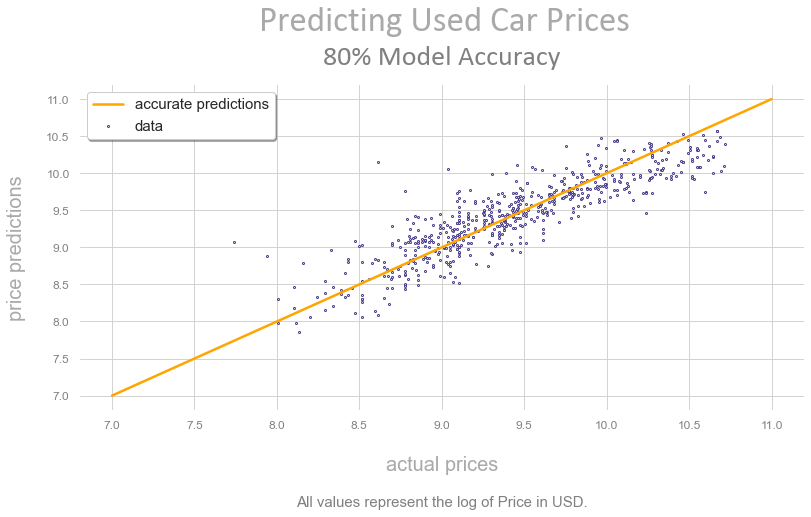

In [53]:
# Create a space to plot the model

plt.figure(figsize=(13,6), facecolor = 'white')

# Plot the predictions
xpoints = np.array([7, 11])
ypoints = np.array([7, 11])
plt.plot(xpoints, ypoints, color = "orange", label = 'accurate predictions', linewidth = 2.5)

# Plot the actual values
ax = plt.scatter(Y_test, Predictions, color = "darkslateblue", s = 4, label = 'data')
ax.set_facecolor('white')
plt.grid(color = 'lightgrey')
# Add a legend
plt.legend(fontsize = 15, shadow = True, fancybox = True)
plt.xticks(color='gray', fontsize = 12)
plt.yticks(color='gray', fontsize = 12)

# Format the x- and y-axes. 
plt.xlabel('actual prices', color = 'darkgrey', fontsize = 20, labelpad = 25)
plt.ylabel('price predictions', color = 'darkgrey', fontsize = 20, labelpad = 20)

# Add a caption
plt.text(9,5.5, "All values represent the log of Price in USD.", ha='center', fontsize = 15, color = 'grey')

# Add a title

plt.suptitle('Predicting Used Car Prices', family = 'calibri', color = 'darkgrey', fontsize = 35, x = .515, y = 1.06)
plt.title('80% Model Accuracy', family = 'calibri', fontsize = 28, color = 'grey', pad = 20)

Our data runs nicely along the line.

In a perfect model, all data points would conform exactly with the orange line; every prediction would match the actual price. While that isn't exactly the case here, it certainly shows that our predictions are more in less in line with the real data, as desired. 